In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
data_path = os.path.join('./data/PEMS04/PEMS04.npz')
data_file = np.load(data_path) # only the first dimension, traffic flow data
data = data_file[data_file.files[0]] 

In [17]:
data.shape # 307个监测点,每个监测点每五分钟监测一次，三个维度flow流量, occupy时间占有率, speed速度的16992个数据

(16992, 307, 3)

In [35]:
a = np.expand_dims(data[:, :, 0], axis=-1)
b = np.expand_dims(data[:, :, 1], axis=-1)
c = np.expand_dims(data[:, :, 2], axis=-1)
a.shape, b.shape, c.shape

((16992, 307, 1), (16992, 307, 1), (16992, 307, 1))

In [38]:
np.concatenate((a, b, c), axis=-1).shape

(16992, 307, 3)

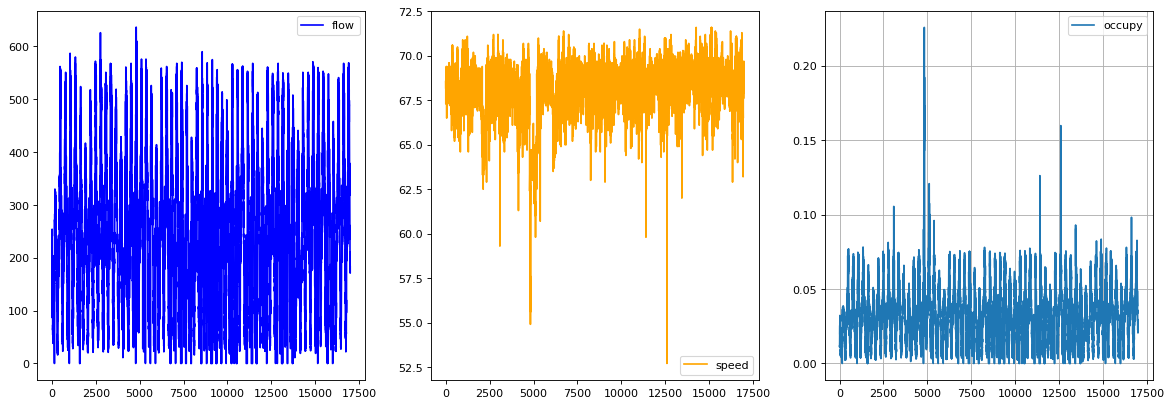

In [4]:
plt.figure(figsize=(18, 6), dpi=80)
plt.subplot(1, 3, 2)
plt.plot(data[:, 100, 2], color='orange', label='speed')
plt.legend(loc='lower right')
plt.subplot(1, 3, 1)
plt.plot(data[:, 100, 0], color='b', label='flow')
plt.legend(loc='upper right')
plt.subplot(1, 3, 3)
plt.plot(data[:, 100, 1], label='occupy')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [5]:
spatio_df = pd.read_csv('./data/PEMS04/PEMS04.csv')
spatio_df

,from,to,cost
0,73,5,352.6
1,5,154,347.2
2,154,263,392.9
3,263,56,440.8
4,56,96,374.6
...,...,...,...
335,46,216,353.6
336,217,98,411.7
337,98,31,3.2
338,217,46,354.0


# pretrain

In [1]:
import torch
import numpy as np
import torch.nn as nn
import argparse
import configparser
from datetime import datetime
from model.Trainer import Trainer
from model.FlashST import FlashST as Network_Pretrain
from model.FlashST import FlashST as Network_Predict
from lib.TrainInits import init_seed
from lib.TrainInits import print_model_parameters
from lib.metrics import MAE_torch, MSE_torch, huber_loss
from lib.predifineGraph import *
from lib.data_process import define_dataloder, get_val_tst_dataloader, data_type_init
from conf.FlashST.Params_pretrain import parse_args
import torch.nn.functional as F
import os

### configs

In [2]:
config_file = './conf/FlashST/config.conf'
config = configparser.ConfigParser()
config.read(config_file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser(prefix_chars='-', description='arguments')

parser.add_argument('-cuda', default=False, type=bool)
parser.add_argument('-device', default=device, type=str, help='indices of GPUs')
parser.add_argument('-mode', default='pretrain', type=str)
parser.add_argument('-model', default='STGCN', type=str)
parser.add_argument('-dataset_test', default='PEMS07M', type=str)
parser.add_argument('-dataset_use', default=config['data']['dataset_use'].split(','))

# data
parser.add_argument('-his', default=config['data']['his'], type=int)
parser.add_argument('-pred', default=config['data']['pred'], type=int)
parser.add_argument('-val_ratio', default=config['data']['val_ratio'], type=float)
parser.add_argument('-test_ratio', default=config['data']['test_ratio'], type=float)
parser.add_argument('-tod', default=config['data']['tod'], type=eval)
parser.add_argument('-normalizer', default=config['data']['normalizer'], type=str)
parser.add_argument('-column_wise', default=config['data']['column_wise'], type=eval)
parser.add_argument('-default_graph', default=config['data']['default_graph'], type=eval)
# model
parser.add_argument('-input_base_dim', default=config['model']['input_base_dim'], type=int)
parser.add_argument('-input_extra_dim', default=config['model']['input_extra_dim'], type=int)
parser.add_argument('-output_dim', default=config['model']['output_dim'], type=int)
parser.add_argument('-node_dim', default=config['model']['node_dim'], type=int)
parser.add_argument('-embed_dim', default=config['model']['embed_dim'], type=int)
parser.add_argument('-num_layer', default=config['model']['num_layer'], type=int)
parser.add_argument('-temp_dim_tid', default=config['model']['temp_dim_tid'], type=int)
parser.add_argument('-temp_dim_diw', default=config['model']['temp_dim_diw'], type=int)
parser.add_argument('-use_lpls', default=config['model']['use_lpls'], type=eval)
parser.add_argument('-if_time_in_day', default=config['model']['if_time_in_day'], type=eval)
parser.add_argument('-if_day_in_week', default=config['model']['if_day_in_week'], type=eval)
parser.add_argument('-if_spatial', default=config['model']['if_spatial'], type=eval)
# train
parser.add_argument('-loss_func', default=config['train']['loss_func'], type=str)
parser.add_argument('-seed', default=config['train']['seed'], type=int)
parser.add_argument('-batch_size', default=config['train']['batch_size'], type=int)
parser.add_argument('-lr_init', default=config['train']['lr_init'], type=float)
parser.add_argument('-lr_decay', default=config['train']['lr_decay'], type=eval)
parser.add_argument('-lr_decay_rate', default=config['train']['lr_decay_rate'], type=float)
parser.add_argument('-lr_decay_step', default=config['train']['lr_decay_step'], type=str)
parser.add_argument('-early_stop', default=config['train']['early_stop'], type=eval)
parser.add_argument('-early_stop_patience', default=config['train']['early_stop_patience'], type=int)
parser.add_argument('-grad_norm', default=config['train']['grad_norm'], type=eval)
parser.add_argument('-max_grad_norm', default=config['train']['max_grad_norm'], type=int)
parser.add_argument('-real_value', default=config['train']['real_value'], type=eval,
                    help='use real value for loss calculation')
parser.add_argument('-pretrain_epochs', default=config['train']['pretrain_epochs'], type=int)
parser.add_argument('-eval_epochs', default=config['train']['eval_epochs'], type=int)
parser.add_argument('-ori_epochs', default=config['train']['ori_epochs'], type=int)
parser.add_argument('-load_pretrain_path', default=config['train']['load_pretrain_path'], type=str)
parser.add_argument('-save_pretrain_path', default=config['train']['save_pretrain_path'], type=str)
parser.add_argument('-debug', default=config['train']['debug'], type=str)
# test
parser.add_argument('-mae_thresh', default=config['test']['mae_thresh'], type=eval)
parser.add_argument('-mape_thresh', default=config['test']['mape_thresh'], type=float)
# log
parser.add_argument('-log_dir', default='./', type=str)
parser.add_argument('-log_step', default=config['log']['log_step'], type=int)
parser.add_argument('-plot', default=config['log']['plot'], type=eval)
args = parser.parse_args(args=[])

print('Mode: ', args.mode, '  model: ', args.model, '  DATASET: ', args.dataset_test,
      '  load_pretrain_path: ', args.load_pretrain_path, '  save_pretrain_path: ', args.save_pretrain_path)

Mode:  pretrain   model:  STGCN   DATASET:  PEMS07M   load_pretrain_path:  GWN_P8437.pth   save_pretrain_path:  P8437_stgcn.pth


In [3]:
def Mkdir(path):
    if os.path.isdir(path):
        pass
    else:
        os.makedirs(path)

def infoNCEloss():
    def loss(q, k):
        T = 0.3
        pos_sim = torch.sum(torch.mul(q, q), dim=-1)
        neg_sim = torch.matmul(q, q.transpose(-1, -2))
        pos = torch.exp(torch.div(pos_sim, T))
        neg = torch.sum(torch.exp(torch.div(neg_sim, T)), dim=-1)
        denominator = neg + pos
        return torch.mean(-torch.log(torch.div(pos, denominator)))
    return loss

def scaler_mae_loss(mask_value):
    def loss(preds, labels, scaler, mask=None):
        if scaler:
            preds = scaler.inverse_transform(preds)
            labels = scaler.inverse_transform(labels)
        mae, mae_loss = MAE_torch(pred=preds, true=labels, mask_value=mask_value)
        # print(mae.shape, mae_loss.shape)
        return mae, mae_loss
    return loss

def scaler_huber_loss(mask_value):
    def loss(preds, labels, scaler, mask=None):
        if scaler:
            preds = scaler.inverse_transform(preds)
            labels = scaler.inverse_transform(labels)
        mae, mae_loss = huber_loss(pred=preds, true=labels, mask_value=mask_value)
        # print(mae.shape, mae_loss.shape)
        return mae, mae_loss
    return loss


In [4]:
if args.model == 'GWN' or args.model == 'MTGNN' or args.model == 'STFGNN' or args.model == 'STGODE' or args.model == 'DMSTGCN':
    seed_mode = False   # for quick running
else:
    seed_mode = True
init_seed(args.seed, seed_mode)

#config log path
current_dir = os.getcwd()
log_dir = os.path.join(current_dir, './SAVE', args.mode, args.model)
Mkdir(log_dir)
args.log_dir = log_dir

#predefine Graph
dataset_graph = []
if args.mode == 'pretrain':
    dataset_graph = args.dataset_use.copy()
else:
    dataset_graph.append(args.dataset_test)
args.dataset_graph = dataset_graph

# get the normalized adjacent matrix, the tensor format normalized adjMatrix, and the eigvector of laplacian transform of adjMatrix
pre_graph_dict(args) 

# assign the data type for the dataset, like speed, flow, etc.
data_type_init(args.dataset_test, args)
if args.model == 'STGODE' or args.model == 'AGCRN' or args.model == 'ASTGCN':
    xavier = True
else:
    xavier = False

args.xavier = xavier

Number of isolated points: 7
Number of isolated points: 26


d:\research\llm4tsProject\FlashST\lib\predifineGraph.py:240: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(d, -0.5).flatten() # 1/sqrt(D)


### load dataset

In [5]:
if args.mode == 'pretrain':
    x_trn_dict, y_trn_dict, _, _, _, _, scaler_dict = define_dataloder(stage='Train', args=args)
    eval_train_loader, eval_val_loader, eval_test_loader, eval_scaler_dict = None, None, None, None
else:
    x_trn_dict, y_trn_dict, scaler_dict = None, None, None
    eval_x_trn_dict, eval_y_trn_dict, eval_x_val_dict, eval_y_val_dict, eval_x_tst_dict, eval_y_tst_dict, eval_scaler_dict = define_dataloder(stage='eval', args=args)
    # zip the input data and label into torch dataloader
    eval_train_loader = get_val_tst_dataloader(eval_x_trn_dict, eval_y_trn_dict, args, shuffle=True)
    eval_val_loader = get_val_tst_dataloader(eval_x_val_dict, eval_y_val_dict, args, shuffle=False)
    eval_test_loader = get_val_tst_dataloader(eval_x_tst_dict, eval_y_tst_dict, args, shuffle=False)

['PEMS08', 'PEMS04'] PEMS08 0.2 0.2
(17856, 170) (10560,)
Load PEMS08 Dataset shaped:  (17856, 170, 3) 1147.0 0.0 230.68069424678473 215.0 float64
Normalize the dataset by Standard Normalization
(10714, 170, 3) 229.64618311390265 145.64368009977815
['PEMS08', 'PEMS04'] PEMS04 0.2 0.2
(16992, 307) (82935,)
Load PEMS04 Dataset shaped:  (16992, 307, 3) 919.0 0.0 211.7007794815878 180.0 float64
Normalize the dataset by Standard Normalization
(10196, 307, 3) 207.24549098260414 156.4852634335345


### init model

In [ ]:
if args.mode == 'pretrain':
    model = Network_Pretrain(args)
    # if torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)
    model = model.to(args.device)
else:
    model = Network_Predict(args)
    # if torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)
    model = model.to(args.device)
    if args.mode == 'eval': # in the fine-tuning stage, directly load the pretrained model which include this FlashST and another mature models
        load_dir = os.path.join(current_dir, './SAVE', 'pretrain', args.model)
        model.load_state_dict(torch.load(load_dir + '/' + args.load_pretrain_path), strict=False)
        print(load_dir + '/' + args.load_pretrain_path)
        print('in the fine-tuning stage, firstly load pretrain model!!!')

print_model_parameters(model, only_num=False)

*****************Model Parameter*****************
predictor.st_conv1.tconv1.align.conv1x1.weight torch.Size([32, 128, 1, 1]) True
predictor.st_conv1.tconv1.align.conv1x1.bias torch.Size([32]) True
predictor.st_conv1.tconv1.conv.weight torch.Size([64, 128, 3, 1]) True
predictor.st_conv1.tconv1.conv.bias torch.Size([64]) True
predictor.st_conv1.sconv.theta torch.Size([32, 32, 3]) True
predictor.st_conv1.sconv.b torch.Size([1, 32, 1, 1]) True
predictor.st_conv1.tconv2.conv.weight torch.Size([64, 32, 3, 1]) True
predictor.st_conv1.tconv2.conv.bias torch.Size([64]) True
predictor.st_conv1.ln_pretrain.0.weight torch.Size([170, 64]) True
predictor.st_conv1.ln_pretrain.0.bias torch.Size([170, 64]) True
predictor.st_conv1.ln_pretrain.1.weight torch.Size([307, 64]) True
predictor.st_conv1.ln_pretrain.1.bias torch.Size([307, 64]) True
predictor.st_conv2.tconv1.align.conv1x1.weight torch.Size([32, 64, 1, 1]) True
predictor.st_conv2.tconv1.align.conv1x1.bias torch.Size([32]) True
predictor.st_conv2

### init loss function, optimizer

In [7]:
if args.loss_func == 'mask_mae':
    if (args.model == 'STSGCN' or args.model == 'STFGNN' or args.model == 'STGODE'):
        loss = scaler_huber_loss(mask_value=args.mape_thresh)
        print('============================scaler_huber_loss')
    else:
        loss = scaler_mae_loss(mask_value=args.mape_thresh)
        print('============================scaler_mae_loss')
    # print(args.model, Mode)
elif args.loss_func == 'mae':
    loss = torch.nn.L1Loss().to(args.device)
elif args.loss_func == 'mse':
    loss = torch.nn.MSELoss().to(args.device)
else:
    raise ValueError

optimizer = torch.optim.Adam(params=model.parameters(), lr=args.lr_init, eps=1.0e-8,
                             weight_decay=0, amsgrad=False)

============================scaler_mae_loss


### learning rate decay

In [8]:
lr_scheduler = None
if args.lr_decay:
    print('Applying learning rate decay.')
    lr_decay_steps = [int(i) for i in list(args.lr_decay_step.split(','))]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                                        milestones=lr_decay_steps,
                                                        gamma=args.lr_decay_rate)

Applying learning rate decay.


### start training

In [ ]:
loss_mse = torch.nn.MSELoss().to(args.device)
loss_ssl = infoNCEloss()
trainer = Trainer(model, loss, loss_ssl, optimizer, x_trn_dict, y_trn_dict, args.A_dict, args.lpls_dict, eval_train_loader,
                       eval_val_loader, eval_test_loader, scaler_dict, eval_scaler_dict, args,
                       lr_scheduler=lr_scheduler)

if args.mode == 'pretrain':
    trainer.train_pretrain()
elif args.mode == 'eval':
    trainer.train_eval()
elif args.mode == 'ori':
    trainer.train_eval()
elif args.mode == 'test':
    # model.load_state_dict(torch.load(log_dir + '/' + args.load_pretrain_path), strict=True)
    # print("Load saved model")
    trainer.eval_test(model, trainer.args, args.A_dict, args.lpls_dict, eval_test_loader, eval_scaler_dict[args.dataset_test], trainer.logger)
else:
    raise ValueError

2024-11-17 10:38: Experiment log path in: d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN


  0%|          | 0/300 [00:00<?, ?it/s]

['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04


2024-11-17 11:14: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  0%|          | 1/300 [35:02<174:36:11, 2102.24s/it]

[Source Train] epoch #1/300: loss is 38.7 pred loss 33.5 ssl loss 5.21, training time is 2102.24
['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04


2024-11-17 11:41: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  1%|          | 2/300 [1:02:16<151:13:55, 1826.97s/it]

[Source Train] epoch #2/300: loss is 28.83 pred loss 23.76 ssl loss 5.06, training time is 1634.25
['PEMS08', 'PEMS04'] PEMS08
the trainning input shape: torch.Size([64, 12, 170, 3]), the label shape: torch.Size([64, 12, 170, 3]), train len: 168, the selected dataset: PEMS08


2024-11-17 11:53: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  1%|          | 3/300 [1:14:31<109:35:19, 1328.35s/it]

[Source Train] epoch #3/300: loss is 24.19 pred loss 19.78 ssl loss 4.42, training time is 734.98
['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04


2024-11-17 12:21: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  1%|▏         | 4/300 [1:42:39<120:54:01, 1470.41s/it]

[Source Train] epoch #4/300: loss is 27.24 pred loss 22.4 ssl loss 4.84, training time is 1688.19
['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04


2024-11-17 12:52: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  2%|▏         | 5/300 [2:13:18<131:21:54, 1603.10s/it]

[Source Train] epoch #5/300: loss is 26.59 pred loss 22.03 ssl loss 4.56, training time is 1838.36
['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04


2024-11-17 13:21: Saving current best model to d:\research\llm4tsProject\FlashST\./SAVE\pretrain\STGCN\STGCN_PEMS07M.pth
  2%|▏         | 6/300 [2:42:44<135:26:37, 1658.50s/it]

[Source Train] epoch #6/300: loss is 25.32 pred loss 21.12 ssl loss 4.2, training time is 1766.02
['PEMS08', 'PEMS04'] PEMS04
the trainning input shape: torch.Size([64, 12, 307, 3]), the label shape: torch.Size([64, 12, 307, 3]), train len: 159, the selected dataset: PEMS04
